#### import library

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms


#### hyper-parameter

In [27]:
EPOCHS = 10
ACC_FREQUENCE = 300
batch_size = 64
learning_rate = 0.01
momentum = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#### prepare dataset

In [7]:
data_hub = './data_hub'
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])


train_dataset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)  
test_dataset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



#### build net work

In [11]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320, 50),
            torch.nn.Linear(50, 10),
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 一层卷积层,一层池化层,一层激活层(图是先卷积后激活再池化，差别不大)
        x = self.conv2(x)  # 再来一次
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入 (batch, 20,4,4) ==> (batch,320), -1 此处自动算出的是320
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）
    
model = Net().to(device)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
  )
)

#### define loss && optimizer

In [19]:
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  # lr学习率，momentum冲量


#### train fn

In [29]:
def train(epoch):
    running_loss = 0.0  # 这整个epoch的loss清零
    running_total = 0
    running_correct = 0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()

        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # 把运行中的loss累加起来，为了下面300次一除
        running_loss += loss.item()
        # 把运行中的准确率acc算出来
        _, predicted = torch.max(outputs.data, dim=1)
        running_total += inputs.shape[0]
        running_correct += (predicted == target).sum().item()

        if batch_idx % ACC_FREQUENCE == (ACC_FREQUENCE-1):  # 没FRE_QUEncE次出一个平均损失,和准确率
            print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_idx + 1, running_loss / ACC_FREQUENCE, 100 * running_correct / running_total))
            running_loss = 0.0  # 这小批的loss清零
            running_total = 0
            running_correct = 0  # 这小批的acc清零
train(1)

[2,   300]: loss: 0.080 , acc: 97.42 %
[2,   600]: loss: 0.084 , acc: 97.62 %
[2,   900]: loss: 0.080 , acc: 97.60 %


#### evaluation fn

In [34]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():  # 测试集不用算梯度
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            total += labels.size(0)  # 张量之间的比较运算
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('[%d / %d]: Accuracy on test set: %.1f %% ' % (epoch+1, EPOCHS, 100 * acc))  # 求测试的准确率，正确数/总数
    return acc

#### save you net

#### main

[1,   300]: loss: 0.054 , acc: 98.43 %
[1,   600]: loss: 0.052 , acc: 98.45 %
[1,   900]: loss: 0.052 , acc: 98.47 %
[1 / 10]: Accuracy on test set: 98.2 % 
[2,   300]: loss: 0.046 , acc: 98.65 %
[2,   600]: loss: 0.054 , acc: 98.37 %
[2,   900]: loss: 0.047 , acc: 98.44 %
[2 / 10]: Accuracy on test set: 98.6 % 
[3,   300]: loss: 0.044 , acc: 98.64 %
[3,   600]: loss: 0.048 , acc: 98.62 %
[3,   900]: loss: 0.042 , acc: 98.74 %
[3 / 10]: Accuracy on test set: 98.5 % 
[4,   300]: loss: 0.041 , acc: 98.77 %
[4,   600]: loss: 0.040 , acc: 98.80 %
[4,   900]: loss: 0.042 , acc: 98.79 %
[4 / 10]: Accuracy on test set: 98.7 % 
[5,   300]: loss: 0.036 , acc: 98.91 %
[5,   600]: loss: 0.037 , acc: 98.88 %
[5,   900]: loss: 0.038 , acc: 98.79 %
[5 / 10]: Accuracy on test set: 98.7 % 
[6,   300]: loss: 0.035 , acc: 98.92 %
[6,   600]: loss: 0.034 , acc: 98.96 %
[6,   900]: loss: 0.036 , acc: 98.89 %
[6 / 10]: Accuracy on test set: 98.7 % 
[7,   300]: loss: 0.035 , acc: 98.95 %
[7,   600]: loss: 0

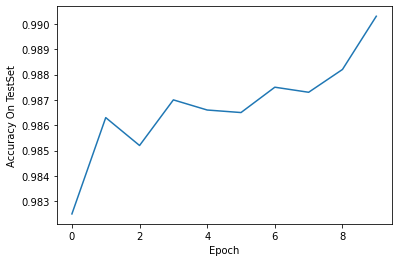

In [35]:
if __name__ == '__main__':
    acc_list_test = []
    for epoch in range(EPOCHS):
        train(epoch)
        # if epoch % 10 == 9:  #每训练10轮 测试1次
        acc_test = test()
        acc_list_test.append(acc_test)

    plt.plot(acc_list_test)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy On TestSet')
    plt.show()